# Домашнее задание. Композиции алгоритмов
В этом домашнем задании вам предстоит обучить два вида композиций алгоритмов: бэггинг и бустинг. 

## Постановка задачи
Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status (семейный статус)
 - occupation (занятие)
 - relationshipы
 - race (раса)
 - sex
 - capital-gain (прирост капитала)
 - capital-loss (капитала потеряно)
 - hours-per-week

## Метрика качества
В качестве целевой метрики мы будем использовать ROC-AUC. Об этой метрике мы говорили в модуле о метриках. Как вы помните, для измерения ROC-AUC требуются вероятности принадлежности к классам. Для решающих деревьев вероятность принадлежности к классу вычисляется как доля объектов из обучающей выборки в соответствующем листе. Для алгоритма, который принимает решение взвешенным голосованием, вероятность вычисляется как среднее взвешенное значение вероятностей по всем алгоритмам в композиции. 

## Ход работы
* Первым делом вы произведете загрузку и обработку данных. В частности, вам необходимо будет закодировать категориальные признаки с помощью One-hot encoding. 
* Сначала мы построим для нашей задачи обычный случайный лес и измерим его качество. Мы подберем оптимальный гиперпараметр "глубина дерева" для случайного леса.
* Далее мы обучим алгоритм градиентного бустинга с помощью библиотеки Catboost. Catboost --- это библиотека для градиентного бустинга, которая автоматически обрабатывает категориальные признаки. Поэтому для этого пункта вам нужно будет использовать не One-hot признаки, а изначальные категориальные признаки.

## Оценивание
В этом домашнем задании данные разделены на две части:
* [`data_train.csv`](https://drive.google.com/file/d/1qKakViWhNT1yTiM66V9hxADAVCYTL0PO/view?usp=share_link). Для этих данных вам известно значение целевой переменной. Эти данные вы будете использовать для обучения. 
* [`data_scoring.csv`](https://drive.google.com/file/d/1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ/view?usp=share_link). На этих данных вы должны будете применить готовую модель, а затем сдать результаты в Stepik. Вам необходимо будет сдать результат работы двух моделей: случайного леса и градиентного бустинга.



## Часть 1. Загрузка и обработка данных
Загрузка данных будет состоять из следующих шагов:
* Загрузка из файла;
* Работа с пропущенными значениями;
* Выделение целевой переменной;
* Разбиение данных на вещественные и категориальные;
* One-hot кодирование категориальных данных;
* Разбиение данных на train и test.

Затем все эти шаги (кроме последнего) необходимо будет применить к `data_scoring`.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!gdown 1qKakViWhNT1yTiM66V9hxADAVCYTL0PO #эта команда скачивает файл data_train.csv и помещает его в корневую директорию Colab. Очень удобно!

zsh:1: command not found: gdown


In [3]:
data = pd.read_csv('data_train.csv')

In [4]:
data.shape

(14734, 14)

In [5]:
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


### Задание
Проведите с данными необходимые операции:

* Замените все знаки "?" на `np.nan`.
* Найдите все столбцы со значениями NaN. Напечатайте их названия.
* Выделите вектор ответов. Закодируйте правильные ответы 0 и 1:
    * '<=50K' -> 0;
    * '>50K' -> 1.
* Сохраните их в отдельную переменную `y` типа `np.array`. 
* Удалите из data правильные ответы.

In [6]:
data.replace('?',np.nan,inplace=True)
data.isna().any()

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

**Вопрос**. В каких колонках присутствуют пропущенные значения?

In [7]:
# Найдите колонки с пропущенными значениями
col_with_nan=data.columns[data.isna().any(axis=0)].to_list()
col_with_nan

['workclass', 'occupation']

In [8]:
y=data['>50K,<=50K'].map({'<=50K':0,'>50K':1}).fillna(data['>50K,<=50K'])
y = y.astype(np.int32, copy=False)
y

0        0
1        0
2        0
3        0
4        1
        ..
14729    0
14730    0
14731    0
14732    0
14733    0
Name: >50K,<=50K, Length: 14734, dtype: int32

Удалим ответы из data.

In [9]:
data = data.drop('>50K,<=50K', axis=1)

**Вопрос**. Какие из признаков являются вещественными?

Выделите вещественные и категориальные признаки.

In [10]:
real_columns=[]
for col in data.columns:
    if data[col].dtype!=object:
        real_columns.append(col)
real_data = data[real_columns]
real_data[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
5,18,446771,10,0,0,25
6,31,108464,12,0,0,40
7,18,423460,7,0,0,36
8,25,110138,9,0,0,40
9,53,167410,13,0,0,40


In [14]:
data.columns
cat_columns = data.select_dtypes(include=['object','category']).columns

cat_data = data[cat_columns]
cat_data[:10]

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
5,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male
6,Federal-gov,Assoc-acdm,Married-civ-spouse,Tech-support,Husband,White,Male
7,NaN,11th,Never-married,NaN,Own-child,White,Male
8,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male
9,Federal-gov,Bachelors,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male


### Задание
Выделите One-hot признаки из данных с помощю объекта `OneHotEncoder` из модуля `sklearn.preprocessing`.

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
ohe = OneHotEncoder(drop='if_binary',handle_unknown='ignore', sparse_output=False)
one_hot_data =  ohe.fit_transform(cat_data) #ВАШ КОД. Выделите one-hot признаки. Используйте метод fit_transform
one_hot_data = pd.DataFrame(one_hot_data, index=cat_data.index)
one_hot_data[:10]

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Наконец, разобьем данные на train и test в соотношении 70:30. 

In [16]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_real_data, test_real_data, \
train_cat_data, test_cat_data, train_one_hot_data, test_one_hot_data, \
y_train, y_test = train_test_split(data, real_data, 
                                   cat_data, one_hot_data, 
                                   y, train_size=0.7)

### Задание
Проделайте все то же самые операции для scoring_data.
* Загрузите данные из файла data_scoring.csv;
* Замените "?" на `np.nan`;
* Выделите числовые и категориальные данные;
* Закодируйте категориальные данные с помощью уже созданного `ohe`. Новый объект класса `OneHotEncoding` создавать не нужно. Используйте метод `ohe.transform`.

In [45]:
!gdown 1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ

zsh:1: command not found: gdown


In [17]:
scoring_data = pd.read_csv('data_scoring.csv')

scoring_data = scoring_data.replace('?',np.nan) #Обработайте пропущенные значения
scoring_real_data = scoring_data.select_dtypes(include='number').columns#ВАШ КОД. Выделите числовые колонки
scoring_cat_data = scoring_data.select_dtypes(include=['object','category']) #ВАШ КОД. Выделите категориальные колонки
scoring_one_hot_data = ohe.transform(scoring_cat_data)#ВАШ КОД. Выделите ohe-признаки. Не забудьте создать pd.DataFrame

## Часть 2. Обучение случайного леса
Мы будем использовать модель `RandomForestClassifier` из `sklearn.ensemble`. Вам предстоит подобрать для случайного леса оптимальный параметр глубины. Количество деревьев в этом задании мы будем использовать постоянным и равным 100. 

Выбор параметра мы будем производить с помощью кросс-валидации на 5 фолдов, используя метод `cross_val_score` из `sklearn.model_selection`. Затем мы обучим окончательную модель на всем `train_data`, а на `test_data` будем считать итоговое качество. 

Отметим, что для моделей `sklearn` мы не можем по умолчанию использовать категориальные признаки. Поэтому мы будем использовать `train/test_one_hot_data`. 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Создадим полную матрицу объекты-признаки. Используем числовые и one-hot данные.

In [19]:
train_data_for_forest = pd.concat([train_real_data, train_one_hot_data], axis='columns')
test_data_for_forest = pd.concat([test_real_data, test_one_hot_data], axis='columns')

### Задание
Выберите оптимальный параметр max_depth от 3 до 19 включительно для модели случаного леса. Используйте кросс-валидацию. Для каждой глубины посчитайте среднее по фолдам значение метрики ROC-AUC и запишите получившиеся данные в массив `rf_metrics`. Используйте 5 фолдов для кросс-валидации.

**Совет**. Для ускорения работы функции `cross_val_score` используйте параметр n_jobs=-1. 

In [20]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 10313 entries, 13835 to 1540
Series name: >50K,<=50K
Non-Null Count  Dtype
--------------  -----
10313 non-null  int32
dtypes: int32(1)
memory usage: 120.9 KB


In [21]:
depths = np.arange(3, 20)
rf_metrics = []

for depth in depths:
    model=RandomForestClassifier(max_depth=depth)
    train_data_for_forest
    train_data_for_forest.columns = train_data_for_forest.columns.astype(str)
    scores = cross_val_score(model,train_data_for_forest,y_train,cv=5,n_jobs=-1,scoring='roc_auc')#ВАШ КОД. Примените кросс-валидацию.
        
    rf_metrics.append(np.mean(scores))

In [ ]:
from sklearn.model_selection import GridSearchCV

# Models for predict
model2=RandomForestClassifier(random_state=42)

# Write params
param={
    "n_estimators": np.arange(100, 1000,100),
    "max_depth": np.arange(3, 20),
    "min_samples_leaf": np.arange(1,3)
}
train_data_for_forest.columns = train_data_for_forest.columns.astype(str)

# Set params for model2
grid_search=GridSearchCV(
    estimator=model2,
    param_grid=param,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=True
)

# Fit model
grid_search.fit(train_data_for_forest,y_train)

# Print result
print(f"Лучшие параметры для случайного леса: {grid_search.best_estimator_}")
print(f"Лучшая метрика ROC-AUC: {grid_search.best_score_}")

Fitting 5 folds for each of 306 candidates, totalling 1530 fits
Лучшие параметры для случайного леса: RandomForestClassifier(max_depth=17, min_samples_leaf=2, n_estimators=400,
                       random_state=42)
Лучшая метрика ROC-AUC: 0.9147041606487409


Построим график получившейся метрики в зависимости от параметра `depth`.

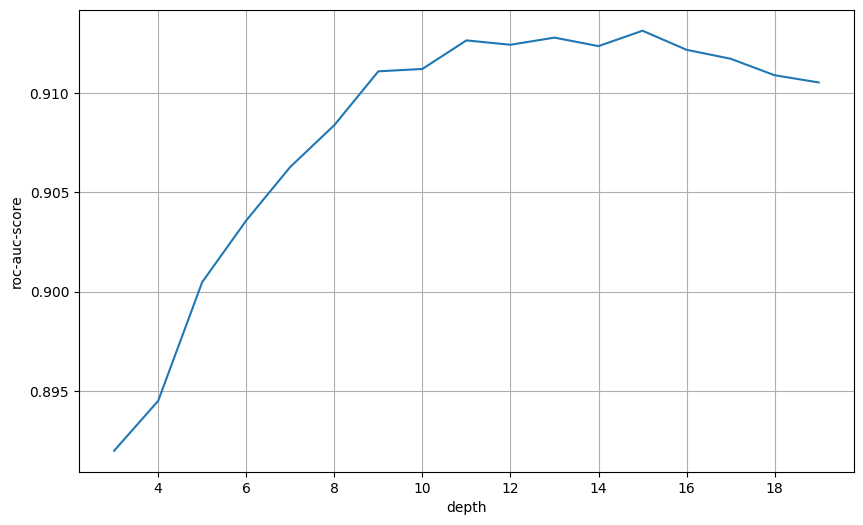

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics)
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()

### Задание
Выберите оптимальное значение глубины и обучите для этого значения единственную модель `RandomForestClassifier` на всех обучающих данных `train_data_for_forest`. Предскажите вероятность класса 1 на обучающих и тестовых данных. Сохраните их в переменные `train_y_pred_forest` и `test_y_pred_forest`. Используйте метод `predict_proba`.

In [ ]:
best_depth = rf_metrics.index(max(rf_metrics))
# display(test_data_for_forest.info())

model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)

# ВАШ КОД. Обучите модель
model.fit(train_data_for_forest,y_train)

test_data_for_forest.columns=test_data_for_forest.columns.astype(str)
train_y_pred_forest = model.predict_proba(train_data_for_forest)
test_y_pred_forest = model.predict_proba(test_data_for_forest)
train_y_pred_forest[:,0][train_y_pred_forest[:,0]>0.5]=1

array([0.2446909, 1.       , 1.       , ..., 1.       , 1.       ,
       1.       ])

array([0.7553091 , 0.01623942, 0.01371123, ..., 0.15098581, 0.1902385 ,
       0.00469184])

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

In [58]:
train_auc = roc_auc_score(y_train,train_y_pred_forest[:,1])
test_auc = roc_auc_score(y_test,test_y_pred_forest[:,1])
display(test_auc)

0.916729022275342

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [50]:
assert test_auc > 0.90

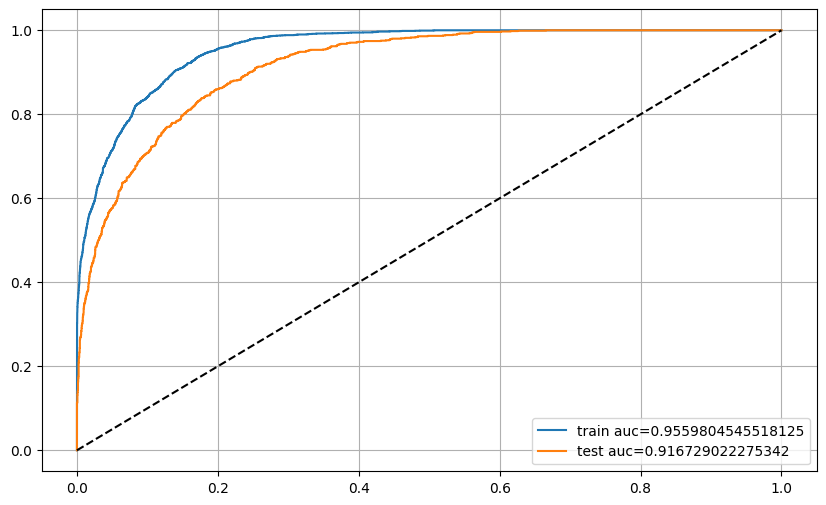

In [60]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_forest[:,1])[:2], 
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_forest[:,1])[:2], 
         label=f'test auc={test_auc}')


plt.plot([0,1], [0,1], '--', color='black')
plt.legend()
plt.grid()

### Задание
Создайте датасет `scoring_data_for_forest` и предскажите на нем целевую переменную.

In [ ]:
scoring_data_for_forest = #ВАШ КОД
scoring_y_pred_forest = #ВАШ КОД

Сохраним scoring_y_pred_forest. Отправьте их на Stepik, полностью скопировав содержимое файла и вставив их вместо "<ВАШ КОД. Вставьте сюда list вероятностей, предсказанных случайным лесом на data_scoring.csv>" так, чтобы переменная answer содержала список вероятностей в нужном порядке.

In [ ]:
with open('scoring_y_pred_forest.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_forest]))

Для посылки на kaggle обычно используют функцию `.to_csv`, как ниже, но нам этот код не понадобится:

In [ ]:
pd.Series(scoring_y_pred_forest).to_csv('scoring_y_pred_forest.csv', header=None, index=None)

## Часть 3. Обучение градиентного бустинга
Мы будем использовать библиотеку Catboost. Catboost --- это библиотека для градиентного бустинга от компании Яндекс. Она, как следует из названия, отличается удобной работой с данными вообще и категориальными признаками с частности. Про Catboost можно прочитать в [официальной документации](https://catboost.ai/en/docs/concepts/python-usages-examples) и в статье на [Хабре](https://habr.com/ru/post/599827/).

<img src="https://avatars.mds.yandex.net/i?id=53d991f7cac35c76bf747793019c39fb-3751806-images-thumbs&n=13&exp=1" style="height:400px; width:800px">

Обратите внимание на следующие моменты:
* В Catboost можно сразу передавать категориальные признаки без предварительного кодирования. 
* В Catboost для категориальных признаков необходимо заполнять пропущенные значения. Мы будем заполнять их значениями `'unknown'`.
* Для работы с данными в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_pool), который называется `Pool`. Прочитать о нем можно также в [примерах использования](https://catboost.ai/en/docs/concepts/python-usages-examples).
* Для кросс-валидации в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_cv) `cv`. Об использовании можно прочитать в статье на [Хабре](https://habr.com/ru/post/599827/).
* Собственно, основная модель для классификации в Catboost --- это `CatBoostClassifier`. 

Для установки `catboost` вы можете выполнить следующую команду. 

In [3]:
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/14/88/ebc0a95d92b9090e6b17a55ceda950d3cbd1ee545286798e8355590501a6/catboost-1.2.8-cp312-cp312-macosx_11_0_universal2.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/02/65/ad2bc85f7377f5cfba5d4466d5474423a3fb7f6a97fd807c06f92dd3e721/plotly-6.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for narwhals>=1.15.1 from https://files.pythonhosted.org/packages/42/bf/fbcbd9f8676e06ed43d644a4ddbf31478a44056487578ce67f191da430cb/narwhals-1.36.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 789.9 kB/s eta 0:00:00-

Импортируем все необходимые классы.

In [4]:
from catboost import CatBoostClassifier, Pool, cv

### Задание
Заполните пропуски в данных `train_cat_data` и `test_cat_data` значением `'unknown'`. Используйте метод `fillna`.

In [ ]:
train_cat_data = #ВАШ КОД
test_cat_data = #ВАШ КОД

### Задание 
Создайте новые наборы данных для train и test, состоящие из `[train/test]_real_data` и `[train/test]_cat_data`. Используйте `pd.concat`. Затем создайте обучающий и тестовый `Pool` (за вас мы выделили номера категориальных признаков). 

In [ ]:
train_data_for_boosting = #ВАШ КОД. Используйте pd.concat
test_data_for_boosting = #ВАШ КОД. Используйте pd.concat

cat_features = np.arange(train_cat_data.shape[1]) + train_real_data.shape[1]

train_dataset = Pool(data=train_data_for_boosting, 
                     label=y_train, 
                     cat_features=cat_features)

test_dataset = # ВАШ КОД. Сделайте то же самое для test

Для каждого значения depth от 3 до 16 включительно используйте функцию `cv` для подсчета результатов кросс-валидации. Затем посчитайте среднее по фолдам значение метрики ROC-AUC с последней итерации и запишите получившиеся данные в массив `boosting_metrics`. 

Обратите внимание, что функция `cv` должна принимать следующие параметры:
* `pool` (используйте `train_dataset`)
* `params` (используйте параметры, указанные в коде)
* `fold_count` (положите равным 5).

Функция cv возвращает pd.DataFrame с метриками обучения. Вам понадобится колонка `'test-AUC-mean'` и последняя строчка. Обратите внимание, что обучение занимает значительное время! Сначала можете попробовать выполнить этот код для небольшого массива `depths`, чтобы было легче дебагать.

In [ ]:
depths = np.arange(3, 17)
boosting_metrics = []

for depth in depths:
    params = {"iterations": 100,
              "depth": depth,
              "loss_function": "Logloss",
              "custom_loss": "AUC",
              "verbose": False}

    scores = #ВАШ КОД. Используйте функцию cv
        
    boosting_metrics.append(<ВАШ КОД>)

Построим график получившейся метрики в зависимости от параметра `depth`. Сравним его с тем же графиком для метрик случайного леса.

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics, label='Random Forest AUC')
plt.plot(np.arange(3, 17), boosting_metrics, label='Catboost AUC')
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()
plt.legend()

Ответье на следующие вопросы:
* Для какой модели общие результаты получились лучше? Если лучше результаты получились у бэггинга, как вы думаете, получится ли у бустинга отыграться на полной выборке и при большем количестве деревьев?
* Какова получилась оптимальная глубина для бустинга? 
* Как она отличается от оптимальной глубины для бэггинга? 

### Задание 
Мы нашли оптмальную глубину. Обучите для этого значения глубины один `CatBoostClassifier` со следующими параметрами:
* `iterations=500` (именно 500, потому что качества с сотней деревьев может не хватить!)
* `depth =` глубина, которую вы нашли
* `loss_function='Logloss'`
* `verbose=False` (чтобы не было лишнего вывода).

Обучение производится с помощью метода `fit`, который принимает единственный аргумент --- `Pool` с данными. В данном случае используйте `train_dataset`.

Предскажите значения на `train_dataset` и `test_dataset`. Это делается методом `predict_proba` (устроен так же, как и в `sklearn`).

In [ ]:
best_depth = #ВАШ КОД

model = #ВАШ КОД. Создайте объект класса CatBoostClassifier

#ВАШ КОД. Обучите модель на train_dataset


train_y_pred_boosting = #ВАШ КОД. Используйте predict_proba
test_y_pred_boosting = #ВАШ КОД. Используйте predict_proba

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [ ]:
train_auc = #ВАШ КОД
test_auc = #ВАШ КОД

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [ ]:
assert test_auc > 0.915

Построим ROC-кривые для получившейся модели.

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_boosting)[:2], 
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_boosting)[:2], 
         label=f'test auc={test_auc}')

plt.plot([0,1], [0,1], '--', color='black')

plt.legend()
plt.grid()

### Задание
Примените построенную модель к данным `scoring_data`. Для этого повторите все шаги, которые вы делали с тестовыми данными:
* Заполнение пропущенных значений
* Конкатенация числовых и категориальных данных
* Создание `scoring_dataset` (здесь не нужно передавать аргумент `label`, так как мы их не знаем)
* Предсказание вероятностей 1 класса

In [ ]:
#ВАШ КОД
scoring_y_pred_boosting = #ВАШ КОД. Сохраните вероятности, предсказанные моделью 

Сохраним предсказанные значения. Отправьте их на Stepik.

In [ ]:
with open('scoring_y_pred_boosting.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_boosting]))